
# Asset Allocation Simulation Project Report 
+ Shashank Nathani
+ sn2954


In [1]:
### Imports 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
## We use memoization so as to avoid reduce repititive calculations for time taking functions
## In our case calculating optimal weights can take some time. 
## When displaying results this reduces runtime to 1/3 of the original time.
## becaue it avoids repated optimzations for OSR, ISR and Turnvoer
class Memoize:
    def __init__(self, fn):
        self.fn = fn
        self.memo = {}
    def __call__(self, *args):
        if args not in self.memo:
            self.memo[args] = self.fn(*args)
        return self.memo[args]

In [3]:
UNI = 2954     # We use this UNI as seed
T = 2400                                          
N = 10                                             
rf = 0.002                                        # risk free rate
kappa = 0.0125                                    # Required return
loading_vector = np.random.uniform(0.5,1.5,N-1)   # loading vector is fixed except when N=50 

In [4]:
def DGP_light(N=N,T=T,alpha = np.zeros(N-1),B = loading_vector,factorReturn = None,seed=UNI) :
    '''data generation process for light tailed distribution
    ----------------------------------------------------------
    return actual return while providing excess to different global variables '''
    global excess_returns,factor_return,e,returns,epsilon_cap    
    excess_returns = np.zeros((N,T))                      
    np.random.seed(seed) 
    factor_return = np.random.normal(0.007,np.sqrt(0.002),T) if factorReturn is None else factorReturn
    SIGMA  = np.diag(np.random.uniform(0.10/np.sqrt(12),0.30/np.sqrt(12),N-1))
    SIGMA  = SIGMA**2
    MU = np.zeros(N-1)
    e = np.ones(N)
    excess_returns[0] = factor_return
    epsilon_cap = np.zeros((N,T))
    epsilon_cap[1:,:] = np.random.multivariate_normal(MU,SIGMA,T).T
    for t in range(T-1):
        excess_returns[1:,t] = alpha + excess_returns[0,t]*B + epsilon_cap[1:,t]
    
    returns = rf+excess_returns   

In [33]:
def DGP_heavy(N=N,T=T,alpha = np.zeros(N-1),B = loading_vector,seed=UNI) :
    '''data generation process for light tailed distribution
    ----------------------------------------------------------
    return actual return while providing excess to different global variables '''
    global excess_returns,factor_return,e,returns,epsilon_cap
    df = 5
    excess_returns = np.zeros((N,T))
    np.random.seed(seed) 
    factor_return = np.sqrt(0.002)*np.random.standard_t(df,T) + 0.007
    e = np.ones(N)
    excess_returns[0] = factor_return
    for t in range(T-1):
        Ut = np.random.chisquare(df,1)
        excess_returns[1:,t] = alpha + excess_returns[0,t]*B + np.sqrt(df/Ut)*epsilon_cap[1:,t]
        
    returns = rf+excess_returns       

Text(0.5, 1.0, 'Random Asset Excess Returns')

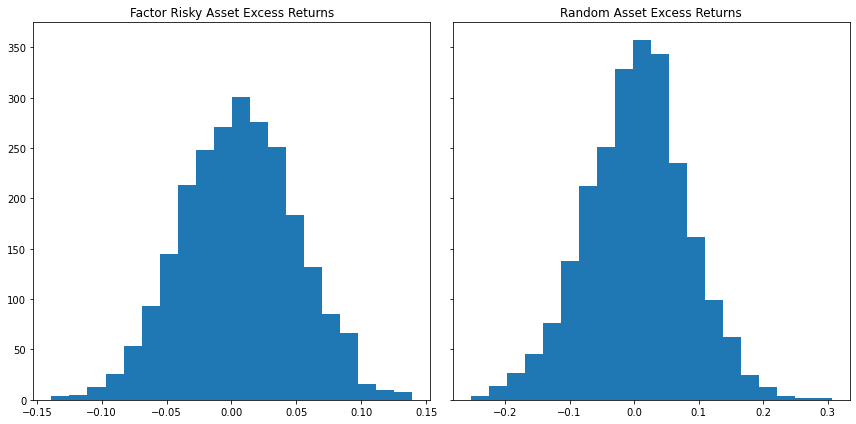

In [6]:
DGP_light()
rand_asset = 5              # any asset to compare with factor asset
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True,figsize=(12,6))
# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(factor_return, bins=20)
axs[0].set_title('Factor Risky Asset Excess Returns')
axs[1].hist(excess_returns[rand_asset], bins=20)
axs[1].set_title('Random Asset Excess Returns')

Text(0.5, 1.0, 'Random Asset Excess Returns')

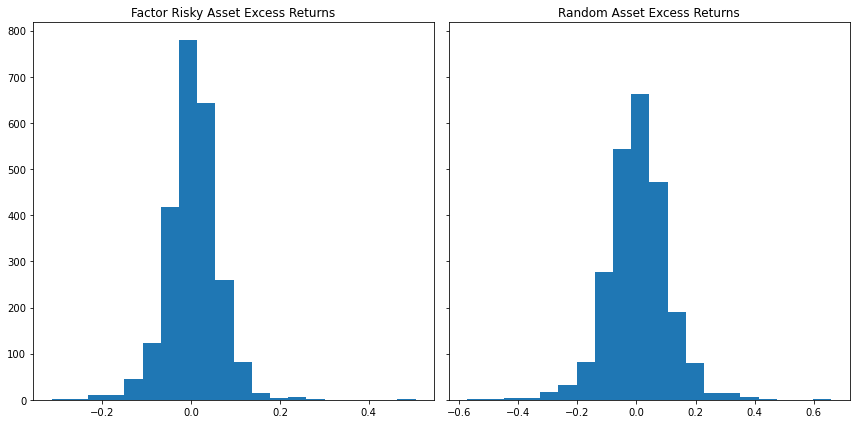

In [7]:
DGP_heavy()
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True,figsize=(12,6))
# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(factor_return, bins=20)
axs[0].set_title('Factor Risky Asset Excess Returns')
axs[1].hist(excess_returns[rand_asset], bins=20)
axs[1].set_title('Random Asset Excess Returns')

In [8]:
def covMatInv(start,end) :
    '''calculating vairance matrix from excess return 
    -------------------------------------
    start : starting index
    end : ending index '''
    global excess_returns
    X = excess_returns[:,start:end]
    sig_inv = np.linalg.inv(np.cov(X))
    return sig_inv

In [9]:
def Optimize(sigma,*args,N=N,obj=None,self_fin = False,short = True) : 
    '''optimization function given objective function and constraints
    ----------------------------------------------------------------
    sigma    : covariance matrix
    *args    : constraints 
    obj      : objective function 
    self_fin : self financing considered 
    short    : shorting allowed
    '''
    bound = tuple((None,None) for i in range(N))
    objective = lambda w : w@np.matmul(sigma,w) if obj is None else obj
    x = np.array([1]+[0]*(N-1))
    constr = [{'type': 'ineq', 'fun' : f} for f in args]
    constr = constr + [{'type' : 'ineq', 'fun' : lambda x:x}] if short==False else constr
    constr = constr + [{'type' : 'eq'  , 'fun' : lambda x: np.dot(x,e) - 1}] if self_fin==True else constr
    solution = minimize(objective, x,method = 'SLSQP',constraints=constr,bounds=bound)
    return solution.x
  

In [10]:
def OSR(method,N=N,M=120) :
    ''' method : method to be used while solving for optimal weights
      M        : rollling window parameter
      T        : ending timestep   '''
    mu_t = []
    for t in range(M-1,T-1) :
        weights = getOptimalWeights(t-M+1,t+1,method,N) 
        mu_t.append(weights@excess_returns[:,t+1])
    osr = (np.mean(mu_t))/np.std(mu_t)     
    return osr


def ISR(method,N=N,M=120) :
    ''' method  : method to be used while solving for optimal weights
      M         : rollling window parameter
      T         : ending timestep '''
    mu_t = []
    for t in range(M-1,T) :
        weights = getOptimalWeights(t-M+1,t+1,method,N)
        mu_t.append(weights@excess_returns[:,t])
    isr = (np.mean(mu_t))/np.std(mu_t)     
    return isr


def Turnover(method,N=N,M=120) :
    ''' method : method to be used while solving for optimal weights
      M        : rollling window parameter
      T        : ending timestep 
    '''
    SUM = 0
    for t in range(M-1,T) :
        SUM += np.sum(abs(getOptimalWeights(t-M+1,t+1,method,N) - getRealizedWeights(t-M+1,t+1,method,N)))
    return SUM/(T-M)

In [11]:
@Memoize                                                             ## We use memoize decoractor to cache results
def getOptimalWeights(start,end,method,N) :
    '''Solves for optimal weights given method
    --------------------------------------------
    start : starting index for excess returns matrix
    end   : ending index for excess returns matrix
    method: allocation method
    N     : number of assets
    '''
    M = end - start
    if method == 'ew' :
        return e/N

    if method == 'mkt' :
        w = np.zeros(N)
        w[0] = 1
        return w

    if method == 'mv' :
        sigma_inv = covMatInv(start,end)
        mu_cap = np.mean(excess_returns[:,start:end],axis=1)
        mult = np.matmul(sigma_inv,mu_cap)
        w = ((kappa-rf)/(mu_cap@mult))*mult
        return w  

    if method == 'u-mv' :
        sigma_inv = covMatInv(start,end)
        mu_cap = np.mean(excess_returns[:,start:end],axis=1)
        mult = np.matmul(sigma_inv,mu_cap)
        w = ((kappa-rf)/(mu_cap@mult))*mult*((M-N-2)/(M-1))
        return w  

    if method == 'bs' :
        sigma_inv = covMatInv(start,end)
        mu_cap = np.mean(excess_returns[:,start:end],axis=1)   + rf
        mu_zero  = e*(mu_cap@np.matmul(sigma_inv,e))/(e@np.matmul(sigma_inv,e))
        alpha = (N+2)/(N+2+(M-N-2)*( (mu_cap-mu_zero)@np.matmul(sigma_inv,(mu_cap-mu_zero)) ) )
        mu_js = mu_zero + (1-alpha)*(mu_cap - mu_zero) 
        mult = np.matmul(sigma_inv,mu_js)
        w = ((kappa-rf)/(mu_js@mult))*mult
        return w

    if method == 'min' :
        sigma_inv = covMatInv(start,end)
        mu_cap = np.mean(excess_returns[:,start:end],axis=1)    
        w = np.matmul(sigma_inv,e)/(e@(np.matmul(sigma_inv,e)))
        return w

    if method == 'mv-c' :
        sigma = np.cov(excess_returns[:,start:end])
        mu_cap = np.mean(excess_returns[:,start:end],axis=1)
        c1,c2 = lambda x : rf + mu_cap@x - kappa,  lambda x : 1-e@x
        w = Optimize(sigma,c1,c2,N=N,short=False)
        return w

    if method == 'bs-c' :
        sigma_inv = covMatInv(start,end)
        sigma = np.cov(excess_returns[:,start:end])
        mu_cap = rf + np.mean(excess_returns[:,start:end],axis=1)   ## actual return 
        mu_zero  = e*(mu_cap@np.matmul(sigma_inv,e))/(e@np.matmul(sigma_inv,e))
        alpha = (N+2)/(N+2+(M-N-2)*( (mu_cap-mu_zero)@np.matmul(sigma_inv,(mu_cap-mu_zero)) ))
        mu_js = mu_zero + (1-alpha)*(mu_cap - mu_zero)
        c1,c2 = lambda x: rf + mu_js@x-kappa, lambda x: 1-e@x
        w = Optimize(sigma,c1,c2,N=N,short=False)
        return w

    if method == 'min-c' :
        sigma = np.cov(excess_returns[:,start:end])
        mu_cap = np.mean(excess_returns[:,start:end],axis=1)
        w = Optimize(sigma,N=N,self_fin=True,short=False)
        return w

    if method == 'r-m-1' :
        delta = 0.004
        sigma = np.cov(excess_returns[:,start:end])
        mu_cap = np.mean(excess_returns[:,start:end],axis=1)
        c1 = lambda x : rf + mu_cap@x - delta*abs(x)-kappa
        w = Optimize(sigma,c1,N=N)
        return w

    if method == 'r-m-2' :
        delta = 0.004
        sigma = np.cov(excess_returns[:,start:end])
        mu_cap = np.mean(excess_returns[:,start:end],axis=1)
        ch_decomp = np.linalg.cholesky(sigma)  # we use cholesky decomposition here for sigma
        c1 = lambda x:  rf + mu_cap@x - delta*np.linalg.norm(np.matmul(ch_decomp,x),2)-kappa
        w = Optimize(sigma,c1,N=N)
        return w
  
    if method == 'dr-mv' :
        delta = 0.004
        sigma = np.cov(excess_returns[:,start:end])
        mu_cap = np.mean(excess_returns[:,start:end],axis=1)
        obj = lambda x : (np.sqrt(x@np.matmul(sigma,x)) + delta*np.linalg.norm(x,2))**2
        c1 = lambda x : rf + mu_cap@x - delta*np.linalg.norm(x,2) - kappa
        w = Optimize(sigma,c1,N=N)
        return w

    if method == 'mv-tru-dist' :
        B = np.insert(loading_vector,0,1)
        distn_mu = 0.007*B
        B = np.asfarray(B)[:, np.newaxis].T
        SIGMA  = np.diag(np.random.uniform(0.10/np.sqrt(12),0.30/np.sqrt(12),N-1))**2
        SIGMA  = np.insert(np.insert(SIGMA,0,0,axis=0),0,0,axis=1)
        distn_sigma = 0.002*np.matmul(B.T,B) + SIGMA
        mult = np.matmul(np.linalg.inv(distn_sigma),distn_mu)
        w = ((kappa-rf)/(distn_mu@mult))*mult
        return w  

@Memoize
def getRealizedWeights(start,end,method,N) :
    if start==0 :
        return getOptimalWeights(start,end,method,N)

    w_prevRebal = getOptimalWeights(start-1,end-1,method,N)
    w_rf = 1-np.sum(w_prevRebal)  # weight allocated to risk free asset
    w_realized  = (w_prevRebal*(1+returns[:,start]))/( w_prevRebal@(1+returns[:,start]) + w_rf*(1+rf) ) 
    return w_realized



In [12]:
def clear_cache() :
    ''' clear memoized data '''
    getRealizedWeights.memo = {}
    getOptimalWeights.memo = {}

In [13]:
def display_results(N=10,M=120) :
    clear_cache()
    fields  = ['ISR','OSR','Turnover']
    results = pd.DataFrame({f:[] for f in fields})
    for alloc in mList : 
        results.loc[alloc] = [eval(f)(alloc,N,M) for f in fields]
    return results

In [14]:
mList = ['ew','mkt','mv','u-mv','bs','min','mv-c','bs-c','min-c','r-m-1','r-m-2','dr-mv']

Testing all the strategies for the given metrics (ISR,OSR and Turnvoer) using both light tail and heavy tailed data

In [ ]:
DGP_light()
display_results()

In [16]:
DGP_heavy()
display_results()

,ISR,OSR,Turnover
ew,0.066053,0.066400,0.049403
mkt,0.072617,0.073185,0.000000
mv,0.260462,-0.013189,0.378691
u-mv,0.260462,-0.013189,0.342699
bs,0.191640,-0.008818,1.168210
min,0.054647,0.043768,0.129236
mv-c,0.142403,0.030332,0.250188
bs-c,0.131071,0.013562,0.251955
min-c,0.058029,0.053209,0.109420
r-m-1,0.244883,-0.010462,0.443238


Part 2.2) Mean Variance Portfolio with true Distribution

In [17]:
DGP_light()
print('OSR: ', OSR('mv-tru-dist'))
print('ISR: ', ISR('mv-tru-dist'))
print('Turnover: ', Turnover('mv-tru-dist'))

OSR:  0.14081476027509138
ISR:  0.1403400786625082
Turnover:  0.026519761821156076


In [34]:
DGP_heavy()
print('OSR: ', OSR('mv-tru-dist'))
print('ISR: ', ISR('mv-tru-dist'))
print('Turnover: ', Turnover('mv-tru-dist'))

OSR:  0.1330070099855384
ISR:  0.131995990543996
Turnover:  0.031462028883451135


Part 3.1)  Effect of Window Length : We increase length of our window size and test our result for both the light and heavy tailed distribution

In [18]:
DGP_light()
display_results(M=500)

,ISR,OSR,Turnover
ew,0.138846,0.139418,0.040779
mkt,0.153968,0.154756,0.000000
mv,0.195828,0.101692,0.249399
u-mv,0.195828,0.101692,0.242951
bs,0.158064,0.123162,0.148127
min,0.128377,0.126393,0.066438
mv-c,0.131909,0.102498,0.104199
bs-c,0.127811,0.101026,0.075866
min-c,0.138490,0.135719,0.059247
r-m-1,0.187317,0.113025,0.285729


In [19]:
DGP_heavy()
display_results(M=500)

,ISR,OSR,Turnover
ew,0.074460,0.074300,0.049517
mkt,0.082708,0.082669,0.000000
mv,0.137408,0.005472,0.399507
u-mv,0.137408,0.005472,0.388306
bs,0.103611,0.045156,0.333158
min,0.061609,0.058286,0.081818
mv-c,0.089527,0.035062,0.135841
bs-c,0.091148,0.035917,0.130292
min-c,0.063767,0.061915,0.066786
r-m-1,0.128670,0.018346,0.468441


Part 3.2) Effect of Asset Number : We increase the number of assets to N=50 from N=10

In [20]:
B=np.random.uniform(0.5,1.5,49)
DGP_light(N=50,alpha=np.zeros(49),B=B)
display_results(N=50)

,ISR,OSR,Turnover
ew,0.133421,0.133906,0.046724
mkt,0.140340,0.140815,0.000000
mv,0.855554,0.017837,0.420956
u-mv,0.855554,0.017837,0.240943
bs,0.762274,0.027967,0.798778
min,0.066601,0.036269,0.382374
mv-c,0.276392,0.079412,0.242306
bs-c,0.245775,0.075657,0.350386
min-c,0.114228,0.097551,0.133343
r-m-1,0.747015,0.041869,0.463459


In [21]:
DGP_heavy(N=50,alpha=np.zeros(49),B=B)
display_results(N=50)

,ISR,OSR,Turnover
ew,0.068055,0.068624,0.056593
mkt,0.072617,0.073185,0.000000
mv,0.842765,-0.003759,0.409816
u-mv,0.842765,-0.003759,0.234563
bs,0.762607,-0.000857,0.832609
min,0.041688,0.011406,0.464746
mv-c,0.224153,0.033325,0.225258
bs-c,0.201314,0.034773,0.335108
min-c,0.057265,0.047900,0.123932
r-m-1,0.765563,0.013453,0.538731


Part 3.3) Effect of alpha: We introduce non-zero alpha in our equations

In [22]:
DGP_light(alpha=np.random.uniform(-0.01,0.01,N-1))
display_results()

,ISR,OSR,Turnover
ew,0.099312,0.099477,0.041067
mkt,0.140340,0.140815,0.000000
mv,0.507841,0.324395,0.153216
u-mv,0.507841,0.324395,0.138629
bs,0.458049,0.321283,0.171645
min,0.225067,0.208273,0.107340
mv-c,0.239615,0.151690,0.214819
bs-c,0.236826,0.161149,0.221333
min-c,0.133961,0.130341,0.128946
r-m-1,0.487949,0.319643,0.244416


In [23]:
DGP_heavy(alpha=np.random.uniform(-0.01,0.01,N-1))
display_results()

,ISR,OSR,Turnover
ew,0.054921,0.055268,0.049591
mkt,0.072617,0.073185,0.000000
mv,0.313425,0.085650,0.252054
u-mv,0.313425,0.085650,0.228182
bs,0.269925,0.072264,0.563731
min,-0.022656,-0.025210,0.129995
mv-c,0.152191,0.078340,0.169460
bs-c,0.157565,0.066242,0.205570
min-c,0.017622,0.015542,0.109595
r-m-1,0.299023,0.082794,0.328979


Part 4) Effect of Intertemporal Correlation

In [24]:
def AR_1() :
    arr = [0.008]
    np.random.seed(UNI)
    for i in range(T-1) :
        arr.append(0.010-0.112*arr[i-1]+np.random.normal(0,0.03))
    return np.array(arr)

In [25]:
DGP_light(factorReturn=AR_1())
display_results()    


,ISR,OSR,Turnover
ew,0.241118,0.240832,0.041644
mkt,0.288112,0.287525,0.000000
mv,0.393806,0.185054,0.195242
u-mv,0.393806,0.185054,0.177136
bs,0.335890,0.233064,0.136141
min,0.255918,0.237686,0.065122
mv-c,0.296160,0.217780,0.232009
bs-c,0.238053,0.170628,0.263795
min-c,0.280301,0.279353,0.023962
r-m-1,0.383622,0.183271,0.275384
